# Process metadata

In [5]:
import pandas as pd
import geopandas as gp
import os

## Append local datetime

In [123]:
points = pd.read_csv('../raw_download/sample_output/points.csv')
points.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2319 entries, 0 to 2318
Data columns (total 68 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   mly_captured_at             1892 non-null   float64
 1   heading                     2319 non-null   float64
 2   mly_creator_id              1892 non-null   float64
 3   orig_id                     2319 non-null   int64  
 4   mly_is_pano                 1892 non-null   object 
 5   mly_sequence_id             1892 non-null   object 
 6   mly_organization_id         0 non-null      float64
 7   city_id                     2319 non-null   int64  
 8   lat                         2319 non-null   float64
 9   lon                         2319 non-null   float64
 10  source                      2319 non-null   object 
 11  kv_autoImgProcessingResult  427 non-null    object 
 12  kv_autoImgProcessingStatus  427 non-null    object 
 13  kv_dateAdded                427 n

### Identify time zone

In [7]:
%%time

cities = pd.read_csv('./sample_data/cities.csv')
cities_tz = cities.copy()

import datetime
import pytz
from tzwhere import tzwhere

def get_timezone_str(city):
    print(city['city'])
    tzw = tzwhere.tzwhere(forceTZ=True)
    tz_str = tzw.tzNameAt(city['city_lat'], city['city_lon'], forceTZ=True)
    return tz_str

from tqdm import tqdm
cities_tz['timezone'] = cities_tz.apply(lambda row: get_timezone_str(row), axis=1)

Singapore


/Users/yujun/opt/anaconda3/envs/ox/lib/python3.10/site-packages/tzwhere/tzwhere.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.timezoneNamesToPolygons[tzname] = WRAP(polys)
/Users/yujun/opt/anaconda3/envs/ox/lib/python3.10/site-packages/tzwhere/tzwhere.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.unprepTimezoneNamesToPolygons[tzname] = WRAP(polys)


Stuttgart
CPU times: user 4.28 s, sys: 338 ms, total: 4.62 s
Wall time: 4.66 s


In [8]:
cities_tz

,city,city_ascii,city_lat,city_lon,country,iso2,iso3,admin_name,capital,population,city_id,img_count,timezone
0,Singapore,Singapore,1.3000,103.8000,Singapore,SG,SGP,Central Singapore,primary,5271000.0,1702341327,594,Asia/Singapore
1,Stuttgart,Stuttgart,48.7761,9.1775,Germany,DE,DEU,Baden-Württemberg,admin,630305.0,1276171358,1725,Europe/Berlin


In [9]:
def get_utcoffset(city):
    tz_str = city['timezone']
    tz = pytz.timezone(tz_str)
    dt = datetime.datetime.now()
    offset = tz.utcoffset(dt).total_seconds()
    return offset

from tzwhere import tzwhere
cities_tz['utc_offset_s'] = cities_tz.apply(lambda row: get_utcoffset(row), axis=1)
cities_tz

,city,city_ascii,city_lat,city_lon,country,iso2,iso3,admin_name,capital,population,city_id,img_count,timezone,utc_offset_s
0,Singapore,Singapore,1.3000,103.8000,Singapore,SG,SGP,Central Singapore,primary,5271000.0,1702341327,594,Asia/Singapore,28800.0
1,Stuttgart,Stuttgart,48.7761,9.1775,Germany,DE,DEU,Baden-Württemberg,admin,630305.0,1276171358,1725,Europe/Berlin,7200.0


In [10]:
cities_tz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   city          2 non-null      object 
 1   city_ascii    2 non-null      object 
 2   city_lat      2 non-null      float64
 3   city_lon      2 non-null      float64
 4   country       2 non-null      object 
 5   iso2          2 non-null      object 
 6   iso3          2 non-null      object 
 7   admin_name    2 non-null      object 
 8   capital       2 non-null      object 
 9   population    2 non-null      float64
 10  city_id       2 non-null      int64  
 11  img_count     2 non-null      int64  
 12  timezone      2 non-null      object 
 13  utc_offset_s  2 non-null      float64
dtypes: float64(4), int64(2), object(8)
memory usage: 352.0+ bytes


In [11]:
cities_tz.to_csv('./sample_data/cities.csv', index=False)

### Calculate local datetime

In [124]:
df = points[['uuid', 'source', 'orig_id', 'mly_captured_at', 'kv_shotDate', 'lat', 'lon', 'city_id']].merge(cities_tz[['city_id', 'timezone', 'utc_offset_s']], on='city_id', how='left')
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2319 entries, 0 to 2318
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   uuid             2319 non-null   object 
 1   source           2319 non-null   object 
 2   orig_id          2319 non-null   int64  
 3   mly_captured_at  1892 non-null   float64
 4   kv_shotDate      427 non-null    object 
 5   lat              2319 non-null   float64
 6   lon              2319 non-null   float64
 7   city_id          2319 non-null   int64  
 8   timezone         2319 non-null   object 
 9   utc_offset_s     2319 non-null   float64
dtypes: float64(4), int64(2), object(4)
memory usage: 199.3+ KB


In [125]:
def get_local_datetime(row):
    if row['source'] == 'Mapillary':
        timestamp = row['mly_captured_at']/1000
        dt = datetime.datetime.fromtimestamp(timestamp)
        dt2 = dt.astimezone(pytz.timezone(row['timezone']))
        return dt2
    else:
        dt_str = row['kv_shotDate'] + ' +0000'
        dt = datetime.datetime.strptime(dt_str, "%Y-%m-%d %H:%M:%S %z")
        dt2 = dt.astimezone(pytz.timezone(row['timezone']))
        return dt2

df['datetime_local'] = df.apply(lambda row: get_local_datetime(row), axis=1)
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2319 entries, 0 to 2318
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   uuid             2319 non-null   object 
 1   source           2319 non-null   object 
 2   orig_id          2319 non-null   int64  
 3   mly_captured_at  1892 non-null   float64
 4   kv_shotDate      427 non-null    object 
 5   lat              2319 non-null   float64
 6   lon              2319 non-null   float64
 7   city_id          2319 non-null   int64  
 8   timezone         2319 non-null   object 
 9   utc_offset_s     2319 non-null   float64
 10  datetime_local   2319 non-null   object 
dtypes: float64(4), int64(2), object(5)
memory usage: 217.4+ KB


In [126]:
meta = points.merge(df[['uuid', 'datetime_local']], on='uuid', how='left')
meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2319 entries, 0 to 2318
Data columns (total 69 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   mly_captured_at             1892 non-null   float64
 1   heading                     2319 non-null   float64
 2   mly_creator_id              1892 non-null   float64
 3   orig_id                     2319 non-null   int64  
 4   mly_is_pano                 1892 non-null   object 
 5   mly_sequence_id             1892 non-null   object 
 6   mly_organization_id         0 non-null      float64
 7   city_id                     2319 non-null   int64  
 8   lat                         2319 non-null   float64
 9   lon                         2319 non-null   float64
 10  source                      2319 non-null   object 
 11  kv_autoImgProcessingResult  427 non-null    object 
 12  kv_autoImgProcessingStatus  427 non-null    object 
 13  kv_dateAdded                427 n

In [127]:
meta['year'] = meta['datetime_local'].apply(lambda x: x.year)
meta['month'] = meta['datetime_local'].apply(lambda x: x.month)
meta['day'] = meta['datetime_local'].apply(lambda x: x.day)
meta['hour'] = meta['datetime_local'].apply(lambda x: x.hour)

In [128]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2319 entries, 0 to 2318
Data columns (total 73 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   mly_captured_at             1892 non-null   float64
 1   heading                     2319 non-null   float64
 2   mly_creator_id              1892 non-null   float64
 3   orig_id                     2319 non-null   int64  
 4   mly_is_pano                 1892 non-null   object 
 5   mly_sequence_id             1892 non-null   object 
 6   mly_organization_id         0 non-null      float64
 7   city_id                     2319 non-null   int64  
 8   lat                         2319 non-null   float64
 9   lon                         2319 non-null   float64
 10  source                      2319 non-null   object 
 11  kv_autoImgProcessingResult  427 non-null    object 
 12  kv_autoImgProcessingStatus  427 non-null    object 
 13  kv_dateAdded                427 n

## Append sequence index for Mapillary data

In [129]:
# please run download_mapillary_seq_idx.py to obtain sequence index before proceeding

In [130]:
read_folder = './sample_data/mly_seqs'

ls_df = []
for name in tqdm(os.listdir(read_folder)):
    if name != '.DS_Store':
        read_path = os.path.join(read_folder, name)
        if os.path.isfile(read_path):
            df = pd.read_csv(read_path)
            ls_df.append(df) 
seqidx = pd.concat(ls_df).drop(columns=['Unnamed: 0']).reset_index(drop=True)

100%|█████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 550.46it/s]


In [131]:
seqidx.head()

,sequenceIndex,id
0,0,783278883996689
1,1,2229500610733814
2,2,781403850767945
3,3,2128689804166888
4,4,1741117416693014


In [132]:
meta = meta.join(seqidx.set_index('id'), on='orig_id', how='left')
meta.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2319 entries, 0 to 2318
Data columns (total 74 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   mly_captured_at             1892 non-null   float64
 1   heading                     2319 non-null   float64
 2   mly_creator_id              1892 non-null   float64
 3   orig_id                     2319 non-null   int64  
 4   mly_is_pano                 1892 non-null   object 
 5   mly_sequence_id             1892 non-null   object 
 6   mly_organization_id         0 non-null      float64
 7   city_id                     2319 non-null   int64  
 8   lat                         2319 non-null   float64
 9   lon                         2319 non-null   float64
 10  source                      2319 non-null   object 
 11  kv_autoImgProcessingResult  427 non-null    object 
 12  kv_autoImgProcessingStatus  427 non-null    object 
 13  kv_dateAdded                427 n

In [133]:
meta_mly = meta[meta['source'] == 'Mapillary']
meta_kv = meta[meta['source'] == 'KartaView']
len(meta_mly)

1892

In [134]:
meta_mly[meta_mly['sequenceIndex'].isnull()]

,mly_captured_at,heading,mly_creator_id,orig_id,mly_is_pano,mly_sequence_id,mly_organization_id,city_id,lat,lon,source,kv_autoImgProcessingResult,kv_autoImgProcessingStatus,kv_dateAdded,kv_dateProcessed,kv_distance,kv_fieldOfView,kv_filepath,kv_filepathLTh,kv_filepathProc,kv_filepathTh,kv_fileurl,kv_fileurlLTh,kv_fileurlProc,kv_fileurlTh,kv_from,kv_gpsAccuracy,kv_hasObd,kv_headers,kv_height,kv_imageLthUrl,kv_imagePartProjection,kv_imageProcUrl,kv_imageThUrl,kv_isUnwrapped,kv_isWrapped,kv_matchLat,kv_matchLng,kv_matchSegmentId,kv_name,kv_orgCode,kv_projection,kv_projectionYaw,kv_qualityDetails,kv_qualityLevel,kv_qualityStatus,kv_rawDataId,kv_sequenceId,kv_sequenceIndex,kv_shotDate,kv_status,kv_storage,kv_to,kv_unwrapVersion,kv_user,kv_videoId,kv_videoIndex,kv_visibility,kv_wayId,kv_width,kv_wrapVersion,kv_address,kv_cameraParameters,kv_countryCode,kv_deviceName,kv_distanceSeq,kv_sequenceType,uuid,datetime_local,year,month,day,hour,sequenceIndex


In [135]:
meta_mly['sequenceIndex'] = meta_mly['sequenceIndex'].astype(int)
meta_mly = meta_mly.rename(columns={'mly_sequence_id': 'sequence_id', 'sequenceIndex': 'sequence_index'}).drop(columns=['kv_sequenceId', 'kv_sequenceIndex'])
meta_kv['kv_sequenceId'] = meta_kv['kv_sequenceId'].astype(int).astype(str)
meta_kv['kv_sequenceIndex'] = meta_kv['kv_sequenceIndex'].astype(int)
meta_kv = meta_kv.rename(columns={'kv_sequenceId': 'sequence_id', 'kv_sequenceIndex': 'sequence_index'}).drop(columns=['mly_sequence_id', 'sequenceIndex'])
meta = pd.concat([meta_mly, meta_kv]).reset_index(drop=True)
meta.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2319 entries, 0 to 2318
Data columns (total 72 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   mly_captured_at             1892 non-null   float64
 1   heading                     2319 non-null   float64
 2   mly_creator_id              1892 non-null   float64
 3   orig_id                     2319 non-null   int64  
 4   mly_is_pano                 1892 non-null   object 
 5   sequence_id                 2319 non-null   object 
 6   mly_organization_id         0 non-null      float64
 7   city_id                     2319 non-null   int64  
 8   lat                         2319 non-null   float64
 9   lon                         2319 non-null   float64
 10  source                      2319 non-null   object 
 11  kv_autoImgProcessingResult  427 non-null    object 
 12  kv_autoImgProcessingStatus  427 non-null    object 
 13  kv_dateAdded                427 n

/var/folders/q9/ztfc9wt509z8qb3p7wtf4_280000gn/T/ipykernel_18643/3103870887.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_mly['sequenceIndex'] = meta_mly['sequenceIndex'].astype(int)
/var/folders/q9/ztfc9wt509z8qb3p7wtf4_280000gn/T/ipykernel_18643/3103870887.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_kv['kv_sequenceId'] = meta_kv['kv_sequenceId'].astype(int).astype(str)
/var/folders/q9/ztfc9wt509z8qb3p7wtf4_280000gn/T/ipykernel_18643/3103870887.py:4: SettingWithCopyWarning: 
A value

## Append additional Mapillary metadata

In [136]:
# please run download_mapillary_metadata_from_api.py to download additional metadata from Mapillary before proceeding

In [137]:
pd.set_option('display.max_columns', None)

### merge

In [138]:
from tqdm import tqdm

folder = './sample_data/mly_additional_metadata'
big_dfs = []
for sub in tqdm(os.listdir(folder)):
    if sub != '.DS_Store':
        small_dfs = []
        for file in tqdm(os.listdir(os.path.join(folder, sub))):
            if file != '.DS_Store':
                path = os.path.join(folder, sub, file)
                small_df = pd.read_csv(path)
                small_dfs.append(small_df)
        big_df = pd.concat(small_dfs)
        big_dfs.append(big_df)
merged = pd.concat(big_dfs)

100%|████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.91s/it]


In [139]:
merged.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1892 entries, 0 to 0
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             1892 non-null   int64  
 1   altitude                       1892 non-null   float64
 2   atomic_scale                   1892 non-null   float64
 3   camera_parameters              1232 non-null   object 
 4   camera_type                    1892 non-null   object 
 5   computed_altitude              1892 non-null   float64
 6   computed_compass_angle         1892 non-null   float64
 7   computed_rotation              1892 non-null   object 
 8   exif_orientation               1892 non-null   int64  
 9   height                         1892 non-null   int64  
 10  merge_cc                       1892 non-null   float64
 11  quality_score                  1892 non-null   int64  
 12  width                          1892 non-null   int6

In [140]:
# in case where 'error.message' or 'error.code' exists in the columns, run this:
# merged = merged[merged['error.message'].isnull()]
# merged = merged.drop(columns=['error.message', 'error.code', 'error.error_subcode']) # please adapt this part according to your need because the exact columns to drop could be different
# merged.info(verbose=True, show_counts=True)

In [141]:
meta.columns

Index(['mly_captured_at', 'heading', 'mly_creator_id', 'orig_id',
       'mly_is_pano', 'sequence_id', 'mly_organization_id', 'city_id', 'lat',
       'lon', 'source', 'kv_autoImgProcessingResult',
       'kv_autoImgProcessingStatus', 'kv_dateAdded', 'kv_dateProcessed',
       'kv_distance', 'kv_fieldOfView', 'kv_filepath', 'kv_filepathLTh',
       'kv_filepathProc', 'kv_filepathTh', 'kv_fileurl', 'kv_fileurlLTh',
       'kv_fileurlProc', 'kv_fileurlTh', 'kv_from', 'kv_gpsAccuracy',
       'kv_hasObd', 'kv_headers', 'kv_height', 'kv_imageLthUrl',
       'kv_imagePartProjection', 'kv_imageProcUrl', 'kv_imageThUrl',
       'kv_isUnwrapped', 'kv_isWrapped', 'kv_matchLat', 'kv_matchLng',
       'kv_matchSegmentId', 'kv_name', 'kv_orgCode', 'kv_projection',
       'kv_projectionYaw', 'kv_qualityDetails', 'kv_qualityLevel',
       'kv_qualityStatus', 'kv_rawDataId', 'kv_shotDate', 'kv_status',
       'kv_storage', 'kv_to', 'kv_unwrapVersion', 'kv_user', 'kv_videoId',
       'kv_videoIndex', 

In [142]:
merged = merged.add_prefix('mly_')
merged.columns

Index(['mly_id', 'mly_altitude', 'mly_atomic_scale', 'mly_camera_parameters',
       'mly_camera_type', 'mly_computed_altitude',
       'mly_computed_compass_angle', 'mly_computed_rotation',
       'mly_exif_orientation', 'mly_height', 'mly_merge_cc',
       'mly_quality_score', 'mly_width', 'mly_make', 'mly_model',
       'mly_computed_geometry.type', 'mly_computed_geometry.coordinates',
       'mly_mesh.id', 'mly_mesh.url', 'mly_sfm_cluster.id',
       'mly_sfm_cluster.url', 'mly_creator.username', 'mly_creator.id'],
      dtype='object')

In [143]:
merged = merged.rename(columns={'mly_id': 'orig_id', 'mly_height': 'height', 'mly_width': 'width'})
merged.columns

Index(['orig_id', 'mly_altitude', 'mly_atomic_scale', 'mly_camera_parameters',
       'mly_camera_type', 'mly_computed_altitude',
       'mly_computed_compass_angle', 'mly_computed_rotation',
       'mly_exif_orientation', 'height', 'mly_merge_cc', 'mly_quality_score',
       'width', 'mly_make', 'mly_model', 'mly_computed_geometry.type',
       'mly_computed_geometry.coordinates', 'mly_mesh.id', 'mly_mesh.url',
       'mly_sfm_cluster.id', 'mly_sfm_cluster.url', 'mly_creator.username',
       'mly_creator.id'],
      dtype='object')

In [144]:
meta = meta.rename(columns={'kv_height': 'height', 'kv_width': 'width'})
meta = meta.merge(merged, on='orig_id', how='left')
meta.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2319 entries, 0 to 2318
Data columns (total 94 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   mly_captured_at                    1892 non-null   float64
 1   heading                            2319 non-null   float64
 2   mly_creator_id                     1892 non-null   float64
 3   orig_id                            2319 non-null   int64  
 4   mly_is_pano                        1892 non-null   object 
 5   sequence_id                        2319 non-null   object 
 6   mly_organization_id                0 non-null      float64
 7   city_id                            2319 non-null   int64  
 8   lat                                2319 non-null   float64
 9   lon                                2319 non-null   float64
 10  source                             2319 non-null   object 
 11  kv_autoImgProcessingResult         427 non-null    objec

In [145]:
meta_mly = meta[meta['source']=='Mapillary']
meta_kv = meta[meta['source']=='KartaView']
meta_mly = meta_mly.rename(columns={'width_y': 'width', 'height_y': 'height'}).drop(columns=['width_x', 'height_x'])
meta_kv = meta_kv.rename(columns={'width_x': 'width', 'height_x': 'height'}).drop(columns=['width_y', 'height_y'])
meta = pd.concat([meta_mly, meta_kv]).reset_index(drop=True)
meta.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2319 entries, 0 to 2318
Data columns (total 92 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   mly_captured_at                    1892 non-null   float64
 1   heading                            2319 non-null   float64
 2   mly_creator_id                     1892 non-null   float64
 3   orig_id                            2319 non-null   int64  
 4   mly_is_pano                        1892 non-null   object 
 5   sequence_id                        2319 non-null   object 
 6   mly_organization_id                0 non-null      float64
 7   city_id                            2319 non-null   int64  
 8   lat                                2319 non-null   float64
 9   lon                                2319 non-null   float64
 10  source                             2319 non-null   object 
 11  kv_autoImgProcessingResult         427 non-null    objec

## Add sequence image count

In [146]:
seq_img_count = meta.groupby('sequence_id').uuid.count().reset_index().rename(columns={'uuid': 'sequence_img_count'})
seq_img_count

,sequence_id,sequence_img_count
0,1YXrVbZ2jh8FvpHzldW6wS,6
1,2kFcjUgiThaAZ1Dl6x3Ond,26
2,5UpKSNJezMsAho4Irt8aTd,8
3,9073001,427
4,AHWuzGmO5vpPyk83hciZBr,50
5,CetkzDNsXSc5ZYJvnriPIM,18
6,Cp8PkABeHXaDxYiGbVhEmR,36
7,Dxyqo2erpF58mQXUwtMWLJ,9
8,IpZomDBX9PL5TCucGgOek3,55
9,Jw7VROdnpD2BMjaQoLAFXe,161


In [147]:
meta.sequence_id.nunique()

29

In [148]:
meta = meta.merge(seq_img_count, on='sequence_id', how='left')
meta.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2319 entries, 0 to 2318
Data columns (total 93 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   mly_captured_at                    1892 non-null   float64
 1   heading                            2319 non-null   float64
 2   mly_creator_id                     1892 non-null   float64
 3   orig_id                            2319 non-null   int64  
 4   mly_is_pano                        1892 non-null   object 
 5   sequence_id                        2319 non-null   object 
 6   mly_organization_id                0 non-null      float64
 7   city_id                            2319 non-null   int64  
 8   lat                                2319 non-null   float64
 9   lon                                2319 non-null   float64
 10  source                             2319 non-null   object 
 11  kv_autoImgProcessingResult         427 non-null    objec

## Standardise camera projection type

In [149]:
meta_mly = meta[meta['source'] == 'Mapillary']
meta_mly = meta_mly.rename(columns={'mly_camera_type': 'projection_type'}).drop(columns=['kv_projection'])
meta_kv = meta[meta['source'] == 'KartaView']
meta_kv = meta_kv.rename(columns={'kv_projection': 'projection_type'}).drop(columns=['mly_camera_type'])
meta = pd.concat([meta_mly, meta_kv], ignore_index=True)

In [150]:
meta.projection_type.value_counts()

perspective    1232
spherical       660
PLANE           427
Name: projection_type, dtype: int64

In [151]:
d = {
    'PLANE': 'perspective',
    'SPHERE': 'spherical'
}
def convert_values(val, d):
    if val in d.keys():
        return d[val]
    else:
        return val
meta['projection_type'] = meta['projection_type'].apply(lambda val: convert_values(val, d))
meta['projection_type'].value_counts()

perspective    1659
spherical       660
Name: projection_type, dtype: int64

## Calculate FOV

### Extract hFoV and vFoV for KartaView data

In [152]:
def extract_hFoV(p):
    if type(p) == str:
        if len(p) == 0:
            return None
        else:
            p = p.replace("'", '"').replace('None', '"None"')
            #print(p)
            p = json.loads(p)
            if 'hFoV' in p.keys():
                hFoV = p['hFoV']
                if type(hFoV) == str:
                    hFoV = float(hFoV)
                return hFoV
            else:
                return None
    else:
        return None
    
def extract_vFoV(p):
    if type(p) == str:
        if len(p) == 0:
            return None
        else:
            p = p.replace("'", '"').replace('None', '"None"')
            #print(p)
            p = json.loads(p)
            if 'vFoV' in p.keys():
                vFoV = p['vFoV']
                if type(vFoV) == str:
                    vFoV = float(vFoV)
                return vFoV
            else:
                return None
    else:
        return None

In [153]:
import json
import numpy as np
meta_kv = meta[meta['source']=='KartaView']
meta_kv['hFoV'] = meta_kv['kv_cameraParameters'].apply(lambda x: extract_hFoV(x))
meta_kv['vFoV'] = meta_kv['kv_cameraParameters'].apply(lambda x: extract_vFoV(x))
meta_kv.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 427 entries, 1892 to 2318
Data columns (total 94 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   mly_captured_at                    0 non-null      float64
 1   heading                            427 non-null    float64
 2   mly_creator_id                     0 non-null      float64
 3   orig_id                            427 non-null    int64  
 4   mly_is_pano                        0 non-null      object 
 5   sequence_id                        427 non-null    object 
 6   mly_organization_id                0 non-null      float64
 7   city_id                            427 non-null    int64  
 8   lat                                427 non-null    float64
 9   lon                                427 non-null    float64
 10  source                             427 non-null    object 
 11  kv_autoImgProcessingResult         427 non-null    obj

/var/folders/q9/ztfc9wt509z8qb3p7wtf4_280000gn/T/ipykernel_18643/3150110319.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_kv['hFoV'] = meta_kv['kv_cameraParameters'].apply(lambda x: extract_hFoV(x))
/var/folders/q9/ztfc9wt509z8qb3p7wtf4_280000gn/T/ipykernel_18643/3150110319.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_kv['vFoV'] = meta_kv['kv_cameraParameters'].apply(lambda x: extract_vFoV(x))


<AxesSubplot:>

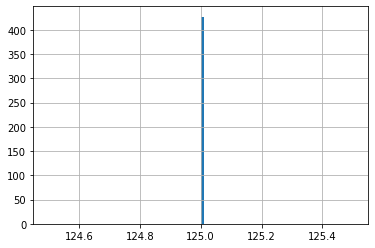

In [154]:
meta_kv.hFoV.hist(bins=100)

<AxesSubplot:>

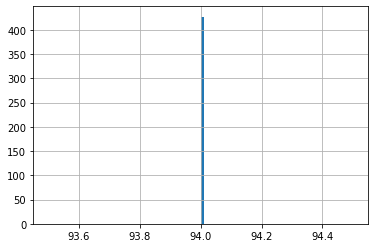

In [155]:
meta_kv.vFoV.hist(bins=100)

In [156]:
print(meta_kv.hFoV.mean())
print(meta_kv.vFoV.mean())

125.0
94.0


In [157]:
meta_kv.projection_type.value_counts()

perspective    427
Name: projection_type, dtype: int64

### Extract hFoV and vFoV for Mapillary data

In [158]:
meta_mly = meta[meta['source'] == 'Mapillary']
meta_mly.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1892 entries, 0 to 1891
Data columns (total 92 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   mly_captured_at                    1892 non-null   float64
 1   heading                            1892 non-null   float64
 2   mly_creator_id                     1892 non-null   float64
 3   orig_id                            1892 non-null   int64  
 4   mly_is_pano                        1892 non-null   object 
 5   sequence_id                        1892 non-null   object 
 6   mly_organization_id                0 non-null      float64
 7   city_id                            1892 non-null   int64  
 8   lat                                1892 non-null   float64
 9   lon                                1892 non-null   float64
 10  source                             1892 non-null   object 
 11  kv_autoImgProcessingResult         0 non-null      objec

In [159]:
meta_mly.head()

,mly_captured_at,heading,mly_creator_id,orig_id,mly_is_pano,sequence_id,mly_organization_id,city_id,lat,lon,source,kv_autoImgProcessingResult,kv_autoImgProcessingStatus,kv_dateAdded,kv_dateProcessed,kv_distance,kv_fieldOfView,kv_filepath,kv_filepathLTh,kv_filepathProc,kv_filepathTh,kv_fileurl,kv_fileurlLTh,kv_fileurlProc,kv_fileurlTh,kv_from,kv_gpsAccuracy,kv_hasObd,kv_headers,kv_imageLthUrl,kv_imagePartProjection,kv_imageProcUrl,kv_imageThUrl,kv_isUnwrapped,kv_isWrapped,kv_matchLat,kv_matchLng,kv_matchSegmentId,kv_name,kv_orgCode,kv_projectionYaw,kv_qualityDetails,kv_qualityLevel,kv_qualityStatus,kv_rawDataId,kv_shotDate,kv_status,kv_storage,kv_to,kv_unwrapVersion,kv_user,kv_videoId,kv_videoIndex,kv_visibility,kv_wayId,kv_wrapVersion,kv_address,kv_cameraParameters,kv_countryCode,kv_deviceName,kv_distanceSeq,kv_sequenceType,uuid,datetime_local,year,month,day,hour,sequence_index,mly_altitude,mly_atomic_scale,mly_camera_parameters,projection_type,mly_computed_altitude,mly_computed_compass_angle,mly_computed_rotation,mly_exif_orientation,height,mly_merge_cc,mly_quality_score,width,mly_make,mly_model,mly_computed_geometry.type,mly_computed_geometry.coordinates,mly_mesh.id,mly_mesh.url,mly_sfm_cluster.id,mly_sfm_cluster.url,mly_creator.username,mly_creator.id,sequence_img_count
0,1.720488e+12,29.878995,1.049480e+14,1666317524185318,True,aE5o7bTMH0UtscOYxhVwID,NaN,1276171358,48.768944,9.171621,Mapillary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,d39b5e69-6291-46fc-a2f8-5947a7e024ee,2024-07-09 03:24:18.913000+02:00,2024,7,9,3,1330,314.146836,1.0,NaN,spherical,2.664304,29.272906,"[1.5313585934181, -0.3999227303244, 0.40079544...",1.0,3840.0,1.018739e+15,0.0,7680.0,none,none,Point,"[9.1716283793269, 48.768947523124]",7.709721e+15,https://scontent-xsp1-3.xx.fbcdn.net/m1/v/t0.4...,1.018739e+15,NaN,ZXStreetview,1.049480e+14,660
1,1.720488e+12,306.414602,1.049480e+14,1014949793367409,True,aE5o7bTMH0UtscOYxhVwID,NaN,1276171358,48.774710,9.172372,Mapillary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,07968c89-5a2a-4913-a870-7eaab4830be5,2024-07-09 03:26:19.834000+02:00,2024,7,9,3,1586,319.259595,1.0,NaN,spherical,0.750562,313.748729,"[1.4801610858631, 0.63207264050649, -0.6301402...",1.0,3840.0,9.880662e+14,0.0,7680.0,none,none,Point,"[9.172378581064, 48.774689383531]",5.074735e+14,https://scontent-xsp1-3.xx.fbcdn.net/m1/v/t0.4...,9.880662e+14,NaN,ZXStreetview,1.049480e+14,660
2,1.720381e+12,157.378575,9.683178e+14,2762100457273030,False,VWRknQTjyX4sEMFlL8CP7h,NaN,1276171358,48.769644,9.169775,Mapillary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f8be9181-606c-4f23-88c5-2608d6cdea7b,2024-07-07 21:33:39.769000+02:00,2024,7,7,21,25,277.086357,1.0,"[0.41827381151087, 0.0099395849338274, -0.0026...",perspective,3.924665,154.928964,"[0.46234916255008, -2.0563453536887, 1.9154043...",1.0,3024.0,1.160629e+15,0.0,4032.0,Apple,iPhone 13 Mini,Point,"[9.1697888460676, 48.769640708701]",1.162746e+15,https://scontent-xsp1-3.xx.fbcdn.net/m1/v/t0.4...,1.160629e+15,NaN,tobi7524,9.683178e+14,50
3,1.720381e+12,156.263669,9.683178e+14,1165840751204664,False,Jw7VROdnpD2BMjaQoLAFXe,NaN,1276171358,48.773321,9.167029,Mapillary,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,b9929935-7b0c-4c57-aca5-8f01fa37ee8b,2024-07-07 21:31:16.047000+02:00,2024,7,7,21,222,278.031500,1.0,"[0.41171082975226, 0.0022740393876939, -0.0014...",perspective,8.20

In [160]:
# do not calculate for:
# equirectangular 
# spherical

import math

def calculate_hFoV(row):
    proj = row['projection_type']
    if (proj == 'equirectangular') or (proj == 'spherical'):
        return None
    else:
        p = row['mly_camera_parameters']
        if type(p) == str:
            #print(p)
            p = json.loads(p)
            fr = float(p[0])
            w = row['width']
            h = row['height']
            hFoV = 2*math.degrees(math.atan(w/(2*fr*max(w, h))))
            return hFoV
        else:
            return None

def calculate_vFoV(row):
    proj = row['projection_type']
    if (proj == 'equirectangular') or (proj == 'spherical'):
        return None
    else:
        p = row['mly_camera_parameters']
        if type(p) == str:
            #print(p)
            p = json.loads(p)
            fr = float(p[0])
            w = row['width']
            h = row['height']
            vFoV = 2*math.degrees(math.atan(h/(2*fr*max(w, h))))
            return vFoV
        else:
            return None

In [161]:
meta_mly.projection_type.value_counts()

perspective    1232
spherical       660
Name: projection_type, dtype: int64

In [162]:
from tqdm import tqdm

hfovs = []
vfovs = []

for _, row in tqdm(meta_mly.iterrows()):
    hfov = calculate_hFoV(row)
    vfov = calculate_vFoV(row)
    hfovs.append(hfov)
    vfovs.append(vfov)

1892it [00:00, 17579.40it/s]


In [163]:
print(len(vfovs))
print(len(hfovs))
print(len(meta_mly))

1892
1892
1892


In [164]:
meta_mly['hFoV'] = hfovs
meta_mly['vFoV'] = vfovs
meta_mly.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1892 entries, 0 to 1891
Data columns (total 94 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   mly_captured_at                    1892 non-null   float64
 1   heading                            1892 non-null   float64
 2   mly_creator_id                     1892 non-null   float64
 3   orig_id                            1892 non-null   int64  
 4   mly_is_pano                        1892 non-null   object 
 5   sequence_id                        1892 non-null   object 
 6   mly_organization_id                0 non-null      float64
 7   city_id                            1892 non-null   int64  
 8   lat                                1892 non-null   float64
 9   lon                                1892 non-null   float64
 10  source                             1892 non-null   object 
 11  kv_autoImgProcessingResult         0 non-null      objec

/var/folders/q9/ztfc9wt509z8qb3p7wtf4_280000gn/T/ipykernel_18643/3904739977.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_mly['hFoV'] = hfovs
/var/folders/q9/ztfc9wt509z8qb3p7wtf4_280000gn/T/ipykernel_18643/3904739977.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta_mly['vFoV'] = vfovs


<AxesSubplot:>

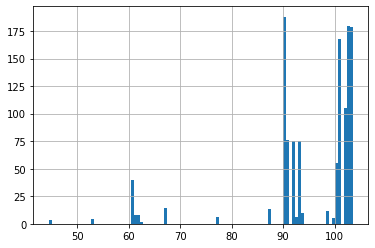

In [165]:
meta_mly.hFoV.hist(bins=100)

<AxesSubplot:>

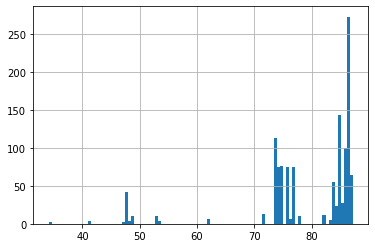

In [166]:
meta_mly.vFoV.hist(bins=100)

In [167]:
print(meta_mly.hFoV.mean())
print(meta_mly.vFoV.mean())

95.39086156167136
79.23736298422806


In [168]:
meta = pd.concat([meta_mly, meta_kv], ignore_index=True)

# Separate metadata into smaller files

In [169]:
meta.columns.tolist()

['mly_captured_at',
 'heading',
 'mly_creator_id',
 'orig_id',
 'mly_is_pano',
 'sequence_id',
 'mly_organization_id',
 'city_id',
 'lat',
 'lon',
 'source',
 'kv_autoImgProcessingResult',
 'kv_autoImgProcessingStatus',
 'kv_dateAdded',
 'kv_dateProcessed',
 'kv_distance',
 'kv_fieldOfView',
 'kv_filepath',
 'kv_filepathLTh',
 'kv_filepathProc',
 'kv_filepathTh',
 'kv_fileurl',
 'kv_fileurlLTh',
 'kv_fileurlProc',
 'kv_fileurlTh',
 'kv_from',
 'kv_gpsAccuracy',
 'kv_hasObd',
 'kv_headers',
 'kv_imageLthUrl',
 'kv_imagePartProjection',
 'kv_imageProcUrl',
 'kv_imageThUrl',
 'kv_isUnwrapped',
 'kv_isWrapped',
 'kv_matchLat',
 'kv_matchLng',
 'kv_matchSegmentId',
 'kv_name',
 'kv_orgCode',
 'kv_projectionYaw',
 'kv_qualityDetails',
 'kv_qualityLevel',
 'kv_qualityStatus',
 'kv_rawDataId',
 'kv_shotDate',
 'kv_status',
 'kv_storage',
 'kv_to',
 'kv_unwrapVersion',
 'kv_user',
 'kv_videoId',
 'kv_videoIndex',
 'kv_visibility',
 'kv_wayId',
 'kv_wrapVersion',
 'kv_address',
 'kv_cameraParame

## metadata_common_attributes (merged attributes)
- lat, lon
- datetime_local
- year, month, day, hour
- width, height
- heading
- projection_type
- hFoV, vFoV
- sequence_index, sequence_id, sequence_img_count

In [170]:
cols = ['uuid',
 'source',
 'orig_id',
 'lat',
 'lon',
 'datetime_local',
 'year',
 'month',
 'day',
 'hour',
 'width',
 'height',
 'heading',
 'projection_type',
 'hFoV',
 'vFoV',
 'sequence_index',
 'sequence_id',
 'sequence_img_count']
meta1 = meta[cols]
meta1.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2319 entries, 0 to 2318
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   uuid                2319 non-null   object 
 1   source              2319 non-null   object 
 2   orig_id             2319 non-null   int64  
 3   lat                 2319 non-null   float64
 4   lon                 2319 non-null   float64
 5   datetime_local      2319 non-null   object 
 6   year                2319 non-null   int64  
 7   month               2319 non-null   int64  
 8   day                 2319 non-null   int64  
 9   hour                2319 non-null   int64  
 10  width               2319 non-null   float64
 11  height              2319 non-null   float64
 12  heading             2319 non-null   float64
 13  projection_type     2319 non-null   object 
 14  hFoV                1659 non-null   float64
 15  vFoV                1659 non-null   float64
 16  sequen

In [171]:
meta1.head()

,uuid,source,orig_id,lat,lon,datetime_local,year,month,day,hour,width,height,heading,projection_type,hFoV,vFoV,sequence_index,sequence_id,sequence_img_count
0,d39b5e69-6291-46fc-a2f8-5947a7e024ee,Mapillary,1666317524185318,48.768944,9.171621,2024-07-09 03:24:18.913000+02:00,2024,7,9,3,7680.0,3840.0,29.878995,spherical,NaN,NaN,1330,aE5o7bTMH0UtscOYxhVwID,660
1,07968c89-5a2a-4913-a870-7eaab4830be5,Mapillary,1014949793367409,48.774710,9.172372,2024-07-09 03:26:19.834000+02:00,2024,7,9,3,7680.0,3840.0,306.414602,spherical,NaN,NaN,1586,aE5o7bTMH0UtscOYxhVwID,660
2,f8be9181-606c-4f23-88c5-2608d6cdea7b,Mapillary,2762100457273030,48.769644,9.169775,2024-07-07 21:33:39.769000+02:00,2024,7,7,21,4032.0,3024.0,157.378575,perspective,100.171826,83.755115,25,VWRknQTjyX4sEMFlL8CP7h,50
3,b9929935-7b0c-4c57-aca5-8f01fa37ee8b,Mapillary,1165840751204664,48.773321,9.167029,2024-07-07 21:31:16.047000+02:00,2024,7,7,21,4032.0,3024.0,156.263669,perspective,101.062438,84.656611,222,Jw7VROdnpD2BMjaQoLAFXe,161
4,c10b66a3-68bd-4dcf-9a86-6b17806e1dfc,Mapillary,1517629215831295,48.764962,9.168434,2024-07-09 03:23:04.172000+02:00,2024,7,9,3,7680.0,3840.0,28.416638,spherical,NaN,NaN,1169,aE5o7bTMH0UtscOYxhVwID,660


In [172]:
meta1.to_csv('./sample_data/02_metadata_common_attributes.csv', index=False)

## metadata_mly (mapillary attributes)
- metadata_mly1, metadata_mly2, metadata_mly3, metadata_mly4, metadata_mly5

In [175]:
meta_mly = meta[meta['source'] == 'Mapillary'].reset_index(drop=True)

In [179]:
cols = ['uuid',
 'source',
 'orig_id',
 'mly_captured_at',
 'mly_camera_parameters',
 'mly_quality_score',
 'mly_altitude',
 'mly_atomic_scale',
 'mly_exif_orientation',
 'mly_is_pano',
 'mly_organization_id']
meta_mly1 = meta_mly[cols]
meta_mly1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1892 entries, 0 to 1891
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   uuid                   1892 non-null   object 
 1   source                 1892 non-null   object 
 2   orig_id                1892 non-null   int64  
 3   mly_captured_at        1892 non-null   float64
 4   mly_camera_parameters  1232 non-null   object 
 5   mly_quality_score      1892 non-null   float64
 6   mly_altitude           1892 non-null   float64
 7   mly_atomic_scale       1892 non-null   float64
 8   mly_exif_orientation   1892 non-null   float64
 9   mly_is_pano            1892 non-null   object 
 10  mly_organization_id    0 non-null      float64
dtypes: float64(6), int64(1), object(4)
memory usage: 162.7+ KB


In [180]:
meta_mly1.to_csv('./sample_data/02_metadata_mly1.csv', index=False)

In [181]:
cols = ['uuid',
 'source',
 'orig_id',
 'mly_computed_altitude',
 'mly_computed_compass_angle',
 'mly_computed_rotation',
 'mly_computed_geometry.type',
 'mly_computed_geometry.coordinates']
meta_mly2 = meta_mly[cols]
meta_mly2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1892 entries, 0 to 1891
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   uuid                               1892 non-null   object 
 1   source                             1892 non-null   object 
 2   orig_id                            1892 non-null   int64  
 3   mly_computed_altitude              1892 non-null   float64
 4   mly_computed_compass_angle         1892 non-null   float64
 5   mly_computed_rotation              1892 non-null   object 
 6   mly_computed_geometry.type         1892 non-null   object 
 7   mly_computed_geometry.coordinates  1892 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 118.4+ KB


In [182]:
meta_mly2.to_csv('./sample_data/02_metadata_mly2.csv', index=False)

In [183]:
cols = ['uuid',
 'source',
 'orig_id',
 'mly_make',
 'mly_model',
 'mly_creator.username',
 'mly_creator.id']
meta_mly3 = meta_mly[cols]
meta_mly3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1892 entries, 0 to 1891
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   uuid                  1892 non-null   object 
 1   source                1892 non-null   object 
 2   orig_id               1892 non-null   int64  
 3   mly_make              1892 non-null   object 
 4   mly_model             1892 non-null   object 
 5   mly_creator.username  1892 non-null   object 
 6   mly_creator.id        1892 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 103.6+ KB


In [184]:
meta_mly3.to_csv('./sample_data/02_metadata_mly3.csv', index=False)

In [185]:
cols = ['uuid', 'source', 'orig_id', 'mly_merge_cc', 'mly_mesh.id', 'mly_mesh.url']
meta_mly4 = meta_mly[cols]
meta_mly4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1892 entries, 0 to 1891
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   uuid          1892 non-null   object 
 1   source        1892 non-null   object 
 2   orig_id       1892 non-null   int64  
 3   mly_merge_cc  1892 non-null   float64
 4   mly_mesh.id   1856 non-null   float64
 5   mly_mesh.url  1856 non-null   object 
dtypes: float64(2), int64(1), object(3)
memory usage: 88.8+ KB


In [186]:
meta_mly4.to_csv('./sample_data/02_metadata_mly4.csv', index=False)

In [187]:
cols = ['uuid', 'source', 'orig_id', 'mly_sfm_cluster.id', 'mly_sfm_cluster.url']
meta_mly5 = meta_mly[cols]
meta_mly5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1892 entries, 0 to 1891
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   uuid                 1892 non-null   object 
 1   source               1892 non-null   object 
 2   orig_id              1892 non-null   int64  
 3   mly_sfm_cluster.id   1892 non-null   float64
 4   mly_sfm_cluster.url  817 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 74.0+ KB


In [188]:
meta_mly5.to_csv('./sample_data/02_metadata_mly5.csv', index=False)

## metadata_kv (kartaview attributes)

In [193]:
meta_kv = meta[meta['source'] == 'KartaView'].reset_index(drop=True)

In [197]:
cols = ['uuid',
 'source',
 'orig_id',
 'kv_shotDate',
 'kv_cameraParameters',
 'kv_qualityDetails',
 'kv_qualityLevel',
 'kv_qualityStatus',
 'kv_autoImgProcessingResult',
 'kv_autoImgProcessingStatus',
 'kv_dateAdded',
 'kv_dateProcessed',
 'kv_distance',
 'kv_fieldOfView',
 'kv_filepath',
 'kv_filepathLTh',
 'kv_filepathProc',
 'kv_filepathTh',
 'kv_fileurl',
 'kv_fileurlLTh',
 'kv_fileurlProc',
 'kv_fileurlTh',
 'kv_from',
 'kv_gpsAccuracy',
 'kv_hasObd',
 'kv_headers',
 'kv_imagePartProjection',
 'kv_isUnwrapped',
 'kv_isWrapped',
 'kv_matchLat',
 'kv_matchLng',
 'kv_matchSegmentId',
 'kv_name',
 'kv_orgCode',
 'kv_projectionYaw',
 'kv_rawDataId',
 'kv_status',
 'kv_storage',
 'kv_to',
 'kv_unwrapVersion',
 'kv_videoId',
 'kv_videoIndex',
 'kv_visibility',
 'kv_wayId',
 'kv_wrapVersion',
 'kv_address',
 'kv_countryCode',
 'kv_deviceName',
 'kv_distanceSeq',
 'kv_sequenceType',
 'kv_user']
meta_kv = meta_kv[cols]

In [198]:
meta_kv.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427 entries, 0 to 426
Data columns (total 51 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   uuid                        427 non-null    object 
 1   source                      427 non-null    object 
 2   orig_id                     427 non-null    int64  
 3   kv_shotDate                 427 non-null    object 
 4   kv_cameraParameters         427 non-null    object 
 5   kv_qualityDetails           0 non-null      float64
 6   kv_qualityLevel             427 non-null    float64
 7   kv_qualityStatus            427 non-null    object 
 8   kv_autoImgProcessingResult  427 non-null    object 
 9   kv_autoImgProcessingStatus  427 non-null    object 
 10  kv_dateAdded                427 non-null    object 
 11  kv_dateProcessed            427 non-null    object 
 12  kv_distance                 0 non-null      float64
 13  kv_fieldOfView              0 non-n

In [199]:
meta_kv.to_csv('./sample_data/02_metadata_kv.csv', index=False)